In [1]:
import re
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.feature_selection import ColumnSelector
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

In [2]:
source_path = "../data/ml-latest"

# Обработка данных

### Обработка movies.csv

In [3]:
movies_df = pd.read_csv(f"{source_path}/movies.csv")
movies_df.sample(5)

,movieId,title,genres
40322,153877,Eve's Christmas (2004),Drama
24526,113793,Reel Bad Arabs: How Hollywood Vilifies a Peopl...,Documentary
15622,79220,Without Bias (a.k.a. Len Bias) (2009),Documentary
50185,175809,Jungle (2017),Action|Adventure|Drama
8337,25735,"Cheat, The (1915)",Drama


In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [5]:
movies_df.rename({
    "movieId": "movie_id"
}, axis=1, inplace=True)

In [6]:
movies_df["genres"].replace("(no genres listed)", None, regex=False, inplace=True)
movies_df.dropna(inplace=True)

PATTERN_YEAR = re.compile(r"\((\d{4})\)$")

movies_df["year"] = movies_df["title"].str.strip().str.extract(PATTERN_YEAR)
movies_df["year"] = movies_df["year"].fillna(movies_df["year"].median()).astype("int16")

movies_df.drop("title", axis=1, inplace=True)

movies_df.sample(5)

,movie_id,genres,year
3072,3158,Drama,1999
51491,178745,Action|Drama,1980
33271,137144,Drama,2014
6934,7045,Children|Fantasy,1990
23843,111544,Documentary,2013


In [7]:
cv = CountVectorizer(token_pattern="[a-z\-]+", binary=True, dtype="int8")
genres_vectors = cv.fit_transform(movies_df["genres"])
genres_list = cv.get_feature_names_out()
movies_df = pd.concat([
    movies_df.reset_index(drop=True).drop("genres", axis=1),
    pd.DataFrame(genres_vectors.todense(), columns=genres_list)
], axis=1)
movies_df.head(5)

,movie_id,year,action,adventure,animation,children,comedy,crime,documentary,drama,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,1,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53832 entries, 0 to 53831
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   movie_id     53832 non-null  int64
 1   year         53832 non-null  int16
 2   action       53832 non-null  int8 
 3   adventure    53832 non-null  int8 
 4   animation    53832 non-null  int8 
 5   children     53832 non-null  int8 
 6   comedy       53832 non-null  int8 
 7   crime        53832 non-null  int8 
 8   documentary  53832 non-null  int8 
 9   drama        53832 non-null  int8 
 10  fantasy      53832 non-null  int8 
 11  film-noir    53832 non-null  int8 
 12  horror       53832 non-null  int8 
 13  imax         53832 non-null  int8 
 14  musical      53832 non-null  int8 
 15  mystery      53832 non-null  int8 
 16  romance      53832 non-null  int8 
 17  sci-fi       53832 non-null  int8 
 18  thriller     53832 non-null  int8 
 19  war          53832 non-null  int8 
 20  wester

In [9]:
del genres_vectors

### Обработка tags.csv

In [10]:
tags_df = pd.read_csv(f"{source_path}/tags.csv")
tags_df.sample(5)

,userId,movieId,tag,timestamp
119003,36917,1777,chick flick,1299654879
420708,73406,143863,escaped slave,1527220746
1028058,258516,1921,psychology,1425167887
145476,47622,99114,music,1372709871
678260,141505,45499,mutants,1184638846


In [11]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108997 entries, 0 to 1108996
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1108997 non-null  int64 
 1   movieId    1108997 non-null  int64 
 2   tag        1108981 non-null  object
 3   timestamp  1108997 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.8+ MB


In [12]:
tags_df.rename({
    "movieId": "movie_id",
    "userId": "user_id"
}, axis=1, inplace=True)
tags_df.drop("timestamp", axis=1, inplace=True)
tags_df.dropna(inplace=True)
tags_df.sample(5)

,user_id,movie_id,tag
253231,68802,106920,bittersweet
834503,189063,215,slow paced
336833,73406,33649,woman director
479102,78279,169190,loss
962515,234668,26326,hallucinatory


In [13]:
PATTERN_CAPS = re.compile(r"[A-Z]+( [A-Z]+)+")
PATTERN_NETFLIX = re.compile(r"^in netflix queue$", flags=re.I)
PATTERN_BASED = re.compile(r"^based on a .*", flags=re.I)
PATTERN_ALPHA = re.compile(r"^[a-z\-]*$", flags=re.I)
PATTERN_ACTOR = re.compile(r"^[A-Z][A-Za-z]+( [A-Z][A-Za-z]+)+$")

tags_df["tag"] = tags_df["tag"].str.strip()
tags_df["tag"].replace("[\.\(\)( - )]", "", regex=True, inplace=True)
tags_df["tag"] = tags_df["tag"].str.replace("/", " ", regex=False)
mask_caps = tags_df["tag"].str.match(PATTERN_CAPS)
tags_df.loc[mask_caps, "tag"] = tags_df.loc[mask_caps, "tag"].str.lower()
mask_phrase = (tags_df["tag"].str.match(PATTERN_BASED) |
               tags_df["tag"].str.match(PATTERN_ACTOR) |
               tags_df["tag"].str.match(PATTERN_NETFLIX))
tags_df.loc[mask_phrase, "tag"] = tags_df.loc[mask_phrase, "tag"].str.replace(" ", "-")
mask_len = tags_df["tag"].map(lambda t: len(t) == 1)
tags_df.loc[mask_len, "tag"] = None
tags_df["tag"] = tags_df["tag"].str.lower()

tags_df.dropna(inplace=True)
tags_df = tags_df.groupby(["user_id", "movie_id"], as_index=False).agg(" ".join)
tags_df.sample(5)

,user_id,movie_id,tag
63144,63786,171689,charlottegainsbourg danstevens director:joseph...
303522,268681,368,clv
145710,103823,68954,pixar sweet
271740,229896,1193,catchyscore exceptionalacting greatadaptations
185308,147263,6356,erlend'sdvds johnsturges


In [14]:
cv = CountVectorizer(
    token_pattern="[\da-z\-]+", stop_words="english",
    max_features=500, min_df=5, max_df=0.8,
    binary=True, dtype="int8"
)
tags_vectors = cv.fit_transform(tags_df["tag"])
tags_list = cv.get_feature_names_out()
tags_df = pd.concat([
    tags_df.reset_index(drop=True).drop("tag", axis=1),
    pd.DataFrame(tags_vectors.todense(), columns=tags_list)
], axis=1)
tags_df.sample(5)

,user_id,movie_id,007,007series,01,02,03,04,05,06,...,xmastheme,yakuza,youngadult,youth,youtube,zachgalifianakis,zacksnyder,zombie,zombies,zooeydeschanel
296288,258370,68659,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140106,103013,8375,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70388,69997,110501,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274593,233686,72156,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168803,130208,4713,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

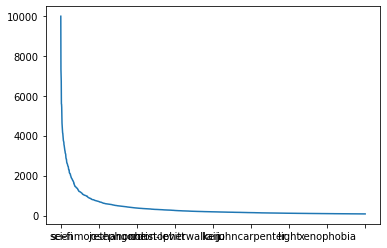

In [15]:
tags_df.drop(["user_id", "movie_id"], axis=1).sum().sort_values(ascending=False).plot()

In [16]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323783 entries, 0 to 323782
Columns: 2002 entries, user_id to zooeydeschanel
dtypes: int64(2), int8(2000)
memory usage: 622.5 MB


In [17]:
del tags_vectors

### Обработка ratings.csv

In [18]:
ratings_df = pd.read_csv(f"{source_path}/ratings.csv")
ratings_df.sample(5)

,userId,movieId,rating,timestamp
27400469,279557,339,3.5,1212080261
6275423,64361,969,5.0,1496171122
8794380,90725,5025,3.0,1504721791
847700,8527,910,2.0,1342565416
12385504,126920,1913,4.0,1095737286


In [19]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [20]:
ratings_df.rename({
    "movieId": "movie_id",
    "userId": "user_id"
}, axis=1, inplace=True)

In [21]:
ratings_df.drop("timestamp", axis=1, inplace=True)
ratings_df["rating"] = ratings_df["rating"].astype("int8")

In [22]:
ratings_df["rating_binary"] = (ratings_df["rating"] >= 4).astype("int8")
ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary
16018819,163594,1375,4,1
18883491,192673,72998,3,0
20799740,212343,4874,1,0
26463912,270256,1210,5,1
25623276,261787,2692,3,0


In [23]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277534 entries, 25142902 to 19013998
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   user_id        277534 non-null  int64
 1   movie_id       277534 non-null  int64
 2   rating         277534 non-null  int8 
 3   rating_binary  277534 non-null  int8 
dtypes: int64(2), int8(2)
memory usage: 6.9 MB


# Подготовка данных для моделей

### Модель жанров

In [24]:
movies_ratings_df = pd.merge(
    ratings_df,
    movies_df,
    on="movie_id"
)

movies_ratings_df["views_count"] = movies_ratings_df.groupby('movie_id')["user_id"].transform('count')
movies_ratings_df["rating_mean"] = movies_ratings_df.groupby('movie_id')["rating"].transform('mean')

movies_ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary,year,action,adventure,animation,children,comedy,...,imax,musical,mystery,romance,sci-fi,thriller,war,western,views_count,rating_mean
83936,259747,6986,4,1,1925,0,1,0,0,0,...,0,0,0,1,0,0,0,0,11,3.636364
2495,30125,1270,3,0,1985,0,1,0,0,1,...,0,0,0,0,1,0,0,0,557,3.822262
509,104564,2167,2,0,1998,1,0,0,0,0,...,0,0,0,0,0,1,0,0,149,3.154362
73234,276946,5349,3,0,2002,1,1,0,0,0,...,0,0,0,0,1,1,0,0,314,3.273885
232672,162871,6155,2,0,2003,0,0,0,0,1,...,0,0,0,1,0,0,0,0,66,2.909091


In [25]:
users_genres_df = pd.concat([
    movies_ratings_df["user_id"].copy(),
    movies_ratings_df[genres_list].mul(movies_ratings_df["rating"], axis=0)
], axis=1)

users_genres_df[genres_list] = users_genres_df[genres_list].replace(0, None)
users_genres_df = users_genres_df.groupby("user_id")[genres_list].mean()
users_genres_df.sample(5)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
user_id,,,,,,,,,,,,,,,,,,,
46322,5.000000,NaN,NaN,NaN,NaN,5.0,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138429,3.333333,3.0,3.0,3.0,3.333333,NaN,NaN,3.666667,NaN,NaN,2.333333,3.0,NaN,2.5,3.0,NaN,2.5,NaN,NaN
255050,2.000000,2.0,NaN,NaN,3.000000,4.0,NaN,3.500000,NaN,NaN,3.000000,NaN,NaN,3.5,2.0,NaN,3.5,NaN,NaN
61010,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
252384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


In [26]:
genres_model_df = pd.merge(
    movies_ratings_df[["user_id", "movie_id", "year", "rating", "rating_mean", "views_count"]],
    users_genres_df,
    on="user_id",
)

genres_model_df["rating_binary"] = (genres_model_df["rating"] >= 4).astype("int8")
genres_model_df.sample(5)

,user_id,movie_id,year,rating,rating_mean,views_count,action,adventure,animation,children,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,rating_binary
269385,268402,171763,2017,4,3.787879,33,3.000000,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1
108778,111690,59429,2007,1,2.181818,11,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,2.0,1.0,4.0,NaN,NaN,0
112909,206116,42,1995,3,3.068966,29,3.142857,3.4,NaN,NaN,...,3.0,4.0,NaN,4.0,3.0,3.5,3.5,NaN,NaN,0
50928,49768,3948,2000,5,3.251121,223,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1
101052,266509,595,1991,3,3.589520,458,5.000000,NaN,3.0,3.0,...,NaN,3.0,3.0,NaN,3.0,NaN,NaN,5.0,NaN,0


In [27]:
genres_model_df.isna().sum()

user_id               0
movie_id              0
year                  0
rating                0
rating_mean           0
views_count           0
action            91251
adventure        107783
animation        203936
children         187495
comedy            75333
crime            135000
documentary      253038
drama             58969
fantasy          165439
film-noir        260276
horror           193895
imax             231364
musical          225955
mystery          185979
romance          128940
sci-fi           136830
thriller          97318
war              214596
western          248277
rating_binary         0
dtype: int64

In [28]:
genres_model_df.dropna(axis=1, how="all", inplace=True)
genres_model_df.fillna(genres_model_df.median(), inplace=True)
genres_model_df.sample(5)

,user_id,movie_id,year,rating,rating_mean,views_count,action,adventure,animation,children,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,rating_binary
99232,30138,2762,1999,0,3.825427,527,3.500000,2.50,3.333333,3.0,...,3.0,3.0,3.0,3.0,2.500000,3.0,3.200000,4.0,2.0,0
255695,239300,3703,1981,4,3.476636,107,4.000000,4.00,3.333333,3.0,...,3.0,3.0,3.0,3.5,3.333333,4.0,4.000000,4.0,3.0,1
181624,117121,589,1991,5,3.880065,617,4.000000,3.25,3.333333,3.0,...,3.0,3.0,3.0,3.5,3.333333,5.0,3.333333,4.0,3.0,1
205847,174562,3535,2000,3,3.495726,117,3.166667,3.25,3.333333,3.0,...,3.0,3.0,3.0,3.0,3.333333,3.0,3.000000,3.0,3.0,0
176678,264946,1375,1984,4,3.125874,143,4.000000,4.00,3.333333,3.0,...,3.0,3.0,3.0,4.0,3.333333,4.0,4.000000,4.0,4.0,1


In [29]:
genres_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277362 entries, 0 to 277361
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        277362 non-null  int64  
 1   movie_id       277362 non-null  int64  
 2   year           277362 non-null  int16  
 3   rating         277362 non-null  int8   
 4   rating_mean    277362 non-null  float64
 5   views_count    277362 non-null  int64  
 6   action         277362 non-null  float64
 7   adventure      277362 non-null  float64
 8   animation      277362 non-null  float64
 9   children       277362 non-null  float64
 10  comedy         277362 non-null  float64
 11  crime          277362 non-null  float64
 12  documentary    277362 non-null  float64
 13  drama          277362 non-null  float64
 14  fantasy        277362 non-null  float64
 15  film-noir      277362 non-null  float64
 16  horror         277362 non-null  float64
 17  imax           277362 non-nul

In [30]:
dtypes_df = genres_model_df.select_dtypes(["float64", "float32"])
genres_model_df[dtypes_df.columns] = dtypes_df.astype("float16")
genres_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277362 entries, 0 to 277361
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        277362 non-null  int64  
 1   movie_id       277362 non-null  int64  
 2   year           277362 non-null  int16  
 3   rating         277362 non-null  int8   
 4   rating_mean    277362 non-null  float16
 5   views_count    277362 non-null  int64  
 6   action         277362 non-null  float16
 7   adventure      277362 non-null  float16
 8   animation      277362 non-null  float16
 9   children       277362 non-null  float16
 10  comedy         277362 non-null  float16
 11  crime          277362 non-null  float16
 12  documentary    277362 non-null  float16
 13  drama          277362 non-null  float16
 14  fantasy        277362 non-null  float16
 15  film-noir      277362 non-null  float16
 16  horror         277362 non-null  float16
 17  imax           277362 non-nul

In [31]:
del movies_df, movies_ratings_df, users_genres_df

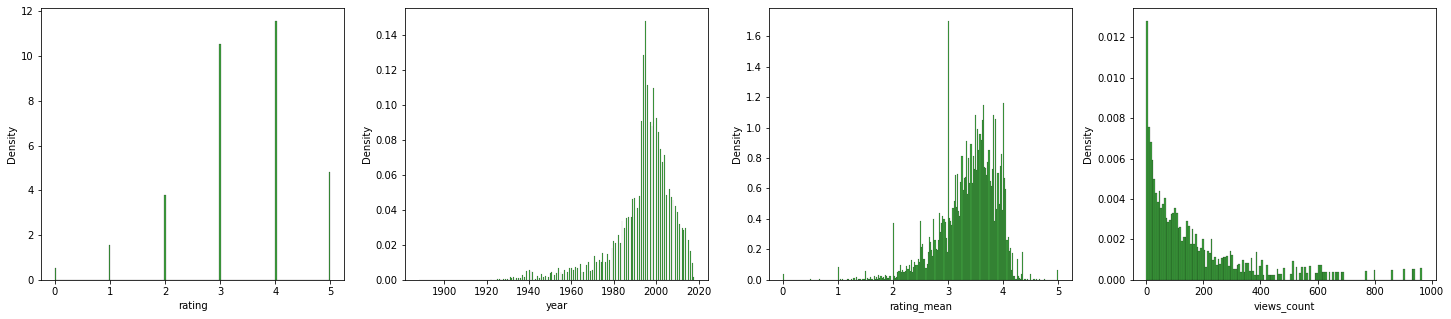

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

for i, feature in enumerate(genres_model_df[["rating", "year", "rating_mean", "views_count"]]):
    sns.histplot(genres_model_df[feature], color="green", stat="density", ax=ax[i])

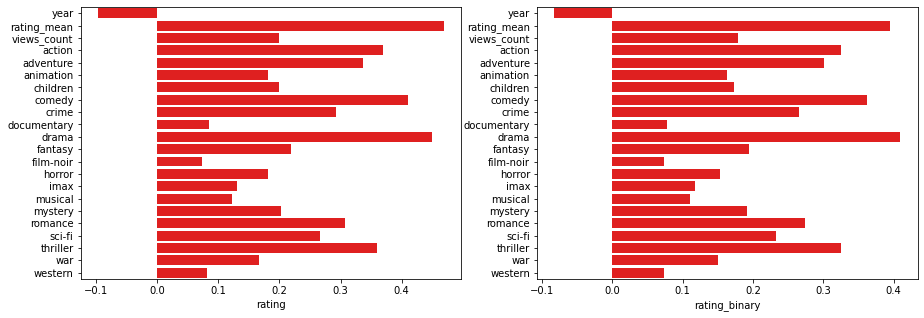

In [33]:
corr = genres_model_df.drop(["user_id", "movie_id"], axis=1).corr().drop(["rating", "rating_binary"])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, feature in enumerate(corr[["rating", "rating_binary"]]):
    sns.barplot(x=corr[feature], y=corr.index, orient="h", color="red", ax=ax[i])

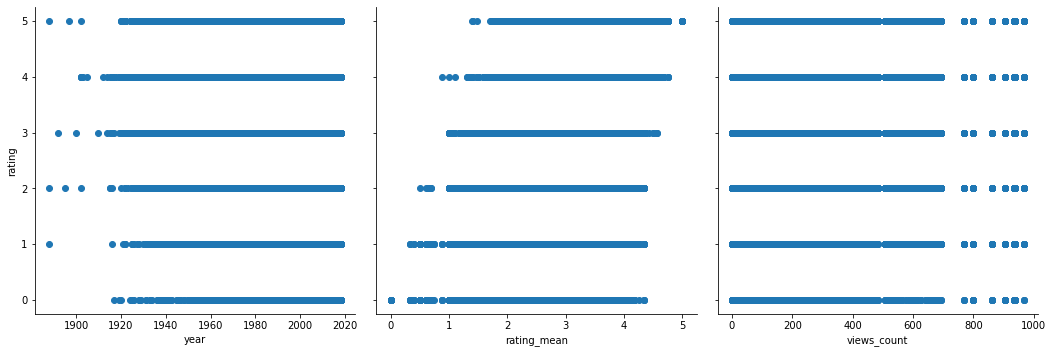

In [34]:
pg = sns.PairGrid(
    genres_model_df,
    x_vars=["year", "rating_mean", "views_count"],
    y_vars="rating",
    height=5,
)

pg.map(plt.scatter)

### Модель тэгов

In [35]:
tags_ratings_df = pd.merge(
    ratings_df.set_index(["user_id", "movie_id"]),
    tags_df.set_index(["user_id", "movie_id"]),
    on=["user_id", "movie_id"]
).reset_index()

tags_ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary,007,007series,01,02,03,04,...,xmastheme,yakuza,youngadult,youth,youtube,zachgalifianakis,zacksnyder,zombie,zombies,zooeydeschanel
478,170758,3623,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1232,272029,47099,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1261,71250,1918,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593,173874,1704,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1658,58489,166015,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
users_tags_df = pd.concat([
    tags_ratings_df["user_id"].copy(),
    tags_ratings_df[tags_list].mul(tags_ratings_df["rating"], axis=0)
], axis=1)

users_tags_df.replace(0, None, inplace=True)
users_tags_df = users_tags_df.groupby("user_id")[tags_list].mean()
users_tags_df.sample(5)

,007,007series,01,02,03,04,05,06,08,09,...,xmastheme,yakuza,youngadult,youth,youtube,zachgalifianakis,zacksnyder,zombie,zombies,zooeydeschanel
user_id,,,,,,,,,,,,,,,,,,,,,
264115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
tags_model_df = pd.merge(
    tags_ratings_df[["user_id", "movie_id", "rating", "rating_binary"]],
    users_tags_df,
    on="user_id"
)
tags_model_df.sample(5)

,user_id,movie_id,rating,rating_binary,007,007series,01,02,03,04,...,xmastheme,yakuza,youngadult,youth,youtube,zachgalifianakis,zacksnyder,zombie,zombies,zooeydeschanel
1682,65878,2571,5,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1761,234710,2360,4,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1123,41892,2762,4,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1886,115043,176371,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1226,132501,34162,4,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
tags_model_df.dropna(axis=1, how="all", inplace=True)
tags_model_df.fillna(tags_model_df.median(), inplace=True)
tags_model_df.sample(5)

,user_id,movie_id,rating,rating_binary,007,007series,10,11,18thcentury,1920s,...,wuxia,wwii,x-men,yakuza,youth,youtube,zacksnyder,zombie,zombies,zooeydeschanel
1935,154772,2596,4,1,2.5,4.0,5.0,5.0,4.0,4.0,...,3.0,4.0,2.0,5.0,3.0,2.5,5.0,3.0,3.0,4.0
654,188863,122926,5,1,2.5,4.0,5.0,5.0,4.0,4.0,...,3.0,4.0,2.0,5.0,3.0,2.5,5.0,3.0,3.0,4.0
122,100294,48520,4,1,2.5,4.0,5.0,5.0,4.0,4.0,...,3.0,4.0,2.0,5.0,3.0,2.5,5.0,3.0,3.0,4.0
1921,161102,58559,5,1,2.5,4.0,5.0,5.0,4.0,4.0,...,3.0,4.0,2.0,5.0,3.0,2.5,5.0,3.0,3.0,4.0
707,63786,8167,3,0,2.5,4.0,5.0,5.0,4.0,4.0,...,3.0,4.0,2.0,5.0,3.0,2.5,5.0,3.0,3.0,4.0


In [39]:
tags_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2168
Columns: 1436 entries, user_id to zooeydeschanel
dtypes: float64(1432), int64(2), int8(2)
memory usage: 23.8 MB


In [40]:
dtypes_df = tags_model_df.select_dtypes(["float64", "float32"])
tags_model_df[dtypes_df.columns] = dtypes_df.astype("float16")
tags_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2168
Columns: 1436 entries, user_id to zooeydeschanel
dtypes: float16(1432), int64(2), int8(2)
memory usage: 6.0 MB


In [41]:
del tags_df, tags_ratings_df, users_tags_df

<AxesSubplot:xlabel='rating', ylabel='Density'>

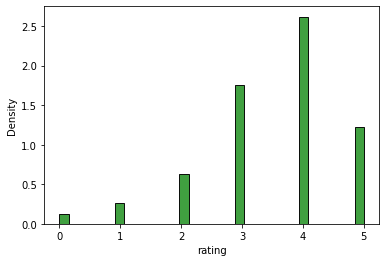

In [42]:
sns.histplot(tags_model_df["rating"], color="green", stat="density")

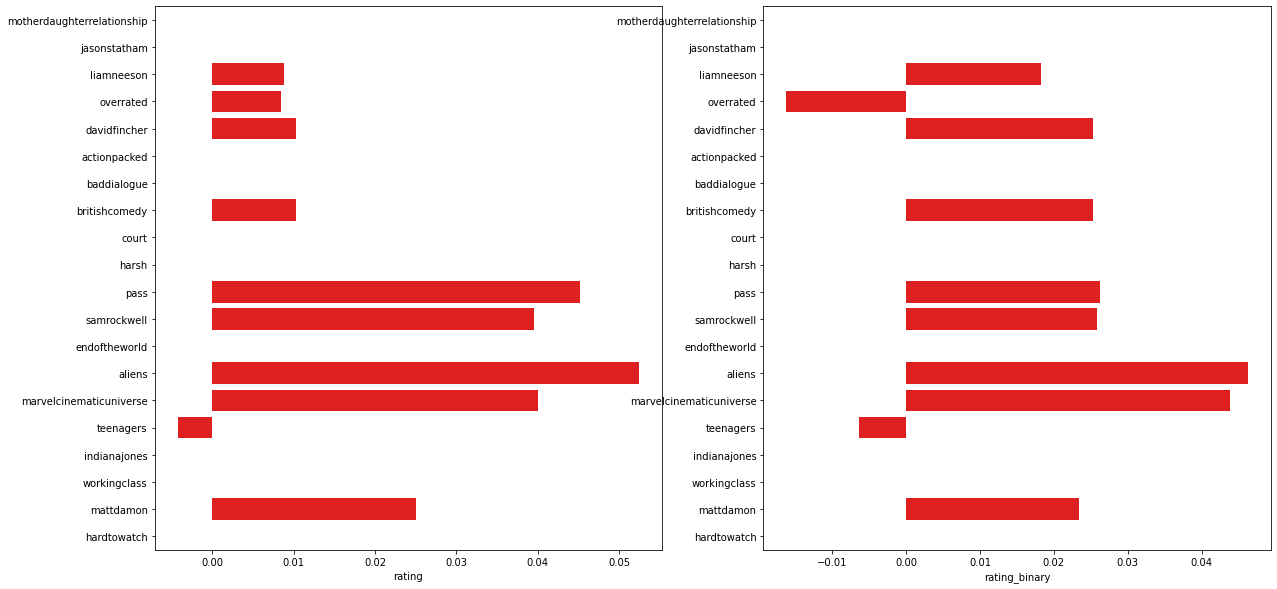

In [43]:
corr = tags_model_df.drop(["user_id", "movie_id"], axis=1).corr().drop(["rating", "rating_binary"]).sample(20)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i, feature in enumerate(corr[["rating", "rating_binary"]]):
    sns.barplot(x=corr[feature], y=corr.index, orient="h", color="red", ax=ax[i])

## Финальная модель

In [44]:
genres_model_renamed_df = genres_model_df.add_suffix("_genres")
tags_model_renamed_df = tags_model_df.add_suffix("_tags")

final_model_df = pd.merge(
    genres_model_renamed_df.set_index(["user_id_genres", "movie_id_genres"]),
    tags_model_renamed_df.set_index(["user_id_tags", "movie_id_tags"]),
    left_on=["user_id_genres", "movie_id_genres"],
    right_on=["user_id_tags", "movie_id_tags"],
)

final_model_df.sample(5)

,year_genres,rating_genres,rating_mean_genres,views_count_genres,action_genres,adventure_genres,animation_genres,children_genres,comedy_genres,crime_genres,...,wuxia_tags,wwii_tags,x-men_tags,yakuza_tags,youth_tags,youtube_tags,zacksnyder_tags,zombie_tags,zombies_tags,zooeydeschanel_tags
240735,1941,5,3.945312,146,3.166016,3.25,3.333984,3.0,3.199219,4.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38998,1996,4,3.582031,230,4.000000,4.00,3.333984,3.0,3.666016,3.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55319,1998,5,2.947266,77,4.500000,4.50,3.333984,3.0,3.199219,3.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175732,2009,4,4.500000,2,3.000000,3.00,3.333984,3.0,3.000000,3.666016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216390,1994,3,3.193359,62,4.000000,4.00,3.333984,3.0,3.500000,3.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
final_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277362 entries, 0 to 277361
Columns: 1458 entries, year_genres to zooeydeschanel_tags
dtypes: float16(1452), float64(2), int16(1), int64(1), int8(2)
memory usage: 777.7 MB


# Моделирование

In [48]:
def display_report(y_test: np.ndarray, y_pred: np.ndarray):
    class_names = set(y_test)
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)

    sns.heatmap(pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred)),
        annot=True)
    plt.ylabel('Действительные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()

    print(metrics.classification_report(y_test, y_pred, zero_division=0))

In [49]:
genres_columns = genres_model_renamed_df.drop([
    "user_id_genres", "movie_id_genres", "rating_genres", "rating_binary_genres"
], axis=1).columns
tags_columns = tags_model_renamed_df.drop([
    "user_id_tags", "movie_id_tags", "rating_tags", "rating_binary_tags"
], axis=1).columns

genres_columns_nums = [genres_model_renamed_df.columns.get_loc(c) for c in genres_columns]
tags_columns_nums = [tags_model_renamed_df.columns.get_loc(c) for c in tags_columns]

x = final_model_df.drop([
    "rating_genres", "rating_binary_genres", "rating_tags", "rating_binary_tags"
], axis=1)
y_multi = final_model_df["rating_genres"]
y_binary = final_model_df["rating_binary_genres"]

In [50]:
del final_model_df, genres_model_renamed_df, tags_model_renamed_df, genres_model_df, tags_model_df

### Мультиклассовая модель

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y_multi, test_size=0.2, stratify=y_multi)

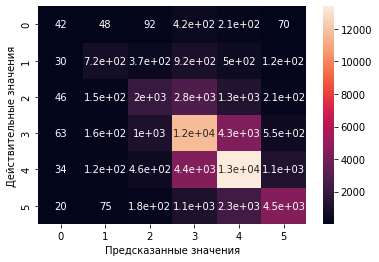

              precision    recall  f1-score   support

           0       0.18      0.05      0.07       886
           1       0.56      0.27      0.37      2652
           2       0.48      0.31      0.38      6426
           3       0.55      0.66      0.60     17803
           4       0.61      0.68      0.64     19551
           5       0.68      0.55      0.61      8155

    accuracy                           0.58     55473
   macro avg       0.51      0.42      0.45     55473
weighted avg       0.58      0.58      0.57     55473



In [52]:
pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
    ("models", StackingClassifier([
        ("genres", Pipeline([
            ("extracting", ColumnSelector(genres_columns_nums)),
            ("rfc", RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())),
        ])),
        ("tags", Pipeline([
            ("extracting", ColumnSelector(tags_columns_nums)),
            ("pca", PCA(n_components=0.4)),
            ("dtc", DecisionTreeClassifier(max_depth=10))
        ]))
    ],
        LogisticRegression(C=10, max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

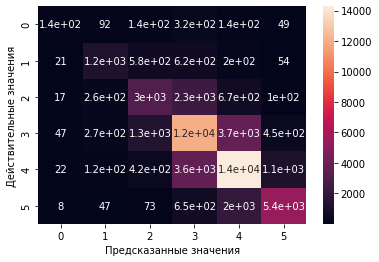

              precision    recall  f1-score   support

           0       0.56      0.16      0.25       886
           1       0.60      0.44      0.51      2652
           2       0.55      0.47      0.51      6426
           3       0.62      0.67      0.64     17803
           4       0.68      0.73      0.70     19551
           5       0.75      0.66      0.70      8155

    accuracy                           0.65     55473
   macro avg       0.63      0.52      0.55     55473
weighted avg       0.65      0.65      0.65     55473



In [53]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", StackingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=50, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=10))
    ],
        LogisticRegression(max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

### Бинарная модель

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, stratify=y_binary)

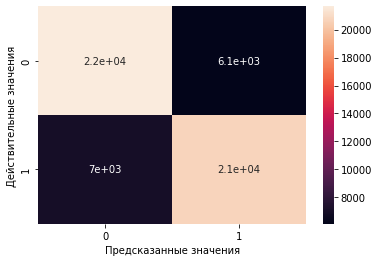

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     27768
           1       0.77      0.75      0.76     27705

    accuracy                           0.76     55473
   macro avg       0.76      0.76      0.76     55473
weighted avg       0.76      0.76      0.76     55473



In [55]:
pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
    ("models", StackingClassifier([
        ("genres", Pipeline([
            ("extracting", ColumnSelector(genres_columns_nums)),
            ("rfc", RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())),
        ])),
        ("tags", Pipeline([
            ("extracting", ColumnSelector(tags_columns_nums)),
            ("dtc", DecisionTreeClassifier(max_depth=10))
        ]))
    ],
        LogisticRegression(C=10, max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

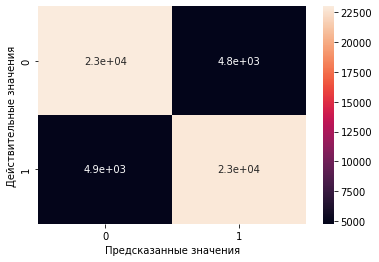

              precision    recall  f1-score   support

           0       0.82      0.83      0.83     27768
           1       0.83      0.82      0.83     27705

    accuracy                           0.83     55473
   macro avg       0.83      0.83      0.83     55473
weighted avg       0.83      0.83      0.83     55473



In [56]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", StackingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=50, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=10))
    ],
        LogisticRegression(max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)